# RAFT

In [1]:
! pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


## Synthetic data generation phase

### Select the documents

In [2]:
import pandas as pd
ds_name = "ucb-DEMO"
doc_path = "sample_data/vampire-bats/surfing/Wakeboarding - Wikipedia.pdf"
ds_path = f"dataset/{ds_name}"
print("Creating dataset: " + ds_name)

Creating dataset: ucb-DEMO


### Overview of PDF

   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBox has zero width or height, which is not allowed.
               Output may be incorrect.
   **** Error: /BBo

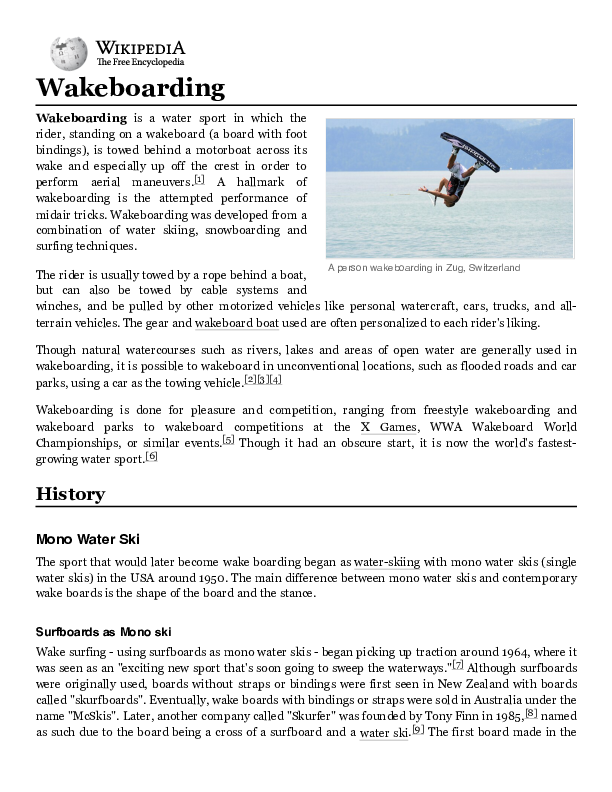

In [3]:
def get_pdf_image(doc_path):
    from wand.image import Image as WImage
    from pathlib import Path
    img = None
    if Path(doc_path).exists() and Path(doc_path).is_file():
        img = WImage(filename=doc_path)

        # make background of img white
        img.format = 'png'
        img.background_color = 'white'
        img.alpha_channel = 'remove'
    return img
get_pdf_image(doc_path)

### Clean up the DEMO folder

In [4]:
# Clean up demo folder only if it's a DEMO dataset
if ds_path.endswith("DEMO"):
    import shutil
    print(f"Cleaning demo folder {ds_path}")
    shutil.rmtree(ds_path, ignore_errors=True)
    print(f"Cleaning demo checkpoints folder {ds_path}")
    shutil.rmtree(ds_path + "-checkpoints", ignore_errors=True)

Cleaning demo folder dataset/ucb-DEMO
Cleaning demo checkpoints folder dataset/ucb-DEMO


### Generate Q/A/CoT fine-tuning dataset using RAFT from the domain specific documents

In [5]:
! python3 .gorilla/raft/raft.py \
    --datapath "$doc_path" \
    --output $ds_path \
    --distractors 3 \
    --doctype pdf \
    --chunk_size 512 \
    --questions 1 \
    --workers 2 \
    --system-prompt-key llama \
    --completion_model Meta-Llama-3-70B-Instruct \
    --embedding_model text-embedding-ada-002

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
2024-07-30 21:12:25  INFO [  0%] raft Using checkpoint chunks /workspaces/llama-raft-recipe/dataset/ucb-DEMO-checkpoints/chunks
2024-07-30 21:12:25  INFO [  0%] raft Retrieving chunks from sample_data/vampire-bats/surfing/Wakeboarding - Wikipedia.pdf of type pdf using the text-embedding-ada-002 model.
Chunking: 100%|██████████████████████| 1/1 [00:00<00:00,  1.09file/s, chunks=16]
2024-07-30 21:12:26  INFO [  0%] raft Using system prompt key llama
2024-07-30 21:12:26  INFO [  0%] raft Using 2 worker threads
Generating: 100%|█| 16/16 [01:48<00:00,  6.81s/chunk, qa=16, last tok/s=2.37e+4,
2024-07-30 21:14:15  INFO [  0%] raft Consumed 12996 prompt tokens, 3424 completion tokens, 16420 total tokens
Creating json from Arrow format: 100%|████████████| 1/1 [00:00<00:00, 25.93ba/s]
2024-07-30 21:14:15  INFO [  0%] raft Generated 16 ques

## Prepare training, validation and evaluation splits

In [6]:
raft_arrow_file = f"{ds_path}/data-00000-of-00001.arrow"
dataset_path = f"{ds_path}-files/{ds_name}-full.jsonl"
dataset_path_hf = f"{ds_path}-files/{ds_name}-hf.full.jsonl"

dataset_path_hf_train = f"{ds_path}-files/{ds_name}-hf.train.jsonl"
dataset_path_hf_valid = f"{ds_path}-files/{ds_name}-hf.valid.jsonl"
dataset_path_hf_eval = f"{ds_path}-files/{ds_name}-hf.eval.jsonl"

dataset_path_ft_train = f"{ds_path}-files/{ds_name}-ft.train.jsonl"
dataset_path_ft_valid = f"{ds_path}-files/{ds_name}-ft.valid.jsonl"
dataset_path_ft_eval = f"{ds_path}-files/{ds_name}-ft.eval.jsonl"

print(f"Reading arrow file {raft_arrow_file}")

Reading arrow file dataset/ucb-DEMO/data-00000-of-00001.arrow


### Export dataset to JSONL

In [7]:
! python ../format.py \
    --input $raft_arrow_file \
    --output $dataset_path_hf \
    --output-format hf

python: can't open file '/workspaces/llama-raft-recipe/../format.py': [Errno 2] No such file or directory


In [8]:
hf_full_df = pd.read_json(dataset_path_hf, lines=True)
hf_full_df.head(5)

,id,type,question,context,oracle_context,cot_answer,instruction
0,7a942314-a33d-4211-8ebe-251cf5f2ff6d,general,What year was the Mathematical Sciences Resear...,{'sentences': [['Robert Oppenheimer was named ...,"In 1964, the Free\nSpeech Movement organized s...","To answer the question, we need to identify th...",<DOCUMENT>Robert Oppenheimer was named\nscient...
1,229b5c74-17c9-4890-a91f-3c76e793bc39,general,What was Berkeley's reported two-year average ...,{'sentences': [['Berkeley had originally repor...,Berkeley had originally reported that its two-...,"To answer the question, we need to identify Be...",<DOCUMENT>Berkeley had originally reported tha...
2,6058ae60-0ccd-42a2-b22a-ea46ad869d7b,general,Who is J.?,{'sentences': [['Dirks 2017–present: Carol T. ...,Physics professor J.,"To answer the question, we need to identify wh...",<DOCUMENT>Dirks\n2017–present: Carol T. Christ...
3,fcf54250-9cb3-419b-8aa6-faa2c2feeec0,general,Who was the chancellor of Birgeneau from 2013 ...,{'sentences': [['Birgeneau 2013–2017 Nicholas ...,Birgeneau\n2013–2017 Nicholas B.,"To answer the question, we need to identify th...",<DOCUMENT>Birgeneau\n2013–2017 Nicholas B.</DO...
4,d5693960-637d-48cd-8bc5-bad22dcff6e9,general,What percentage of the Best Colleges ranking i...,"{'sentences': [['In 1952, the university reorg...",The alumni giving rate accounts for five perce...,"To answer the question, we need to identify th...","<DOCUMENT>In 1952, the university\nreorganized..."


# Let's look at a sample

In [9]:
from IPython.display import display, Markdown
from random import randint
sample_idx = randint(0, len(hf_full_df) - 1)
sample = hf_full_df.iloc[sample_idx]
instruction_md = sample.instruction.replace("<DOCUMENT>", "`<DOCUMENT>`").replace("</DOCUMENT>", "`</DOCUMENT>`")
oracle_context_md = sample.oracle_context.replace("<DOCUMENT>", "`<DOCUMENT>`").replace("</DOCUMENT>", "`</DOCUMENT>`")
sample_answer_md = sample.cot_answer.replace("<ANSWER>", "`<ANSWER>`").replace("##begin_quote##", "`##begin_quote##`").replace("##end_quote##", "`##end_quote##`")
display(Markdown(f"## Oracle Context\n{oracle_context_md}\n\n## Question\n{sample.question}\n\n## CoT Answer\n{sample_answer_md}\n\n## Instruction\n{instruction_md}"))

## Oracle Context
Strong
1965–1965 Martin E.

## Question
Who was Martin E. in 1965?

## CoT Answer
To answer the question, we need to identify who Martin E. was in 1965.

The context provided gives us the necessary information to determine this.
First, we look for the part of the context that directly mentions Martin E. and 1965.
We find it in the sentence: `##begin_quote##`1965–1965 Martin E.`##end_quote##`.

From this sentence, we understand that Martin E. is associated with the year 1965, but the context does not provide any additional information about who Martin E. is or what role he played.

Therefore, based on the context provided, we can conclude that Martin E. was someone or something associated with 1965, but the context does not provide enough information to determine who or what Martin E. was.

`<ANSWER>`: Someone or something associated with 1965

## Instruction
`<DOCUMENT>`Robert Oppenheimer was named
scientific head of the Manhattan Project in 1942.[45][46] Along with
the Lawrence Berkeley National Laboratory, Berkeley founde d and
was then a partner in managing two other labs, Los Alamos
National Laboratory (1943) and Lawrence Livermore National
Laboratory (1952) . In 1952, the University of California reorganized itself into a system
of semi-autonom ous campuses, with each campus given a
chancellor, and Clark Kerr became Berkeley's first Chancellor,
while  Robert Sproul remained in place as the President of the
University of California.[47] Berkeley gained a worldwide
reputation for political activism in the 1960s.`</DOCUMENT>`
`<DOCUMENT>`Bowker
1980–1990 Ira Michael Heyman
1990–1997 Chang-Lin Tien
1997–2004 Robert M.`</DOCUMENT>`
`<DOCUMENT>`In 1952, the university
reorganized itself into a system of semi-autonom ous campuses, with each campus having its own chief
executive, a chancellor, who would, in turn, report to the president of the university system. Twelve vice-
chancellors report directly to Berkeley's chancellor, and the deans of the fifteen colleges and schools report
to the executive vice chancellor and provost, Berkeley's chief academic officer.[88] Twenty-three presidents
and chancellors have led Berkeley since its foundi ng.[89][47]
Presidents
1868–1869 Henry Durant
1869–1870 John LeConte
1870–1872 Henry Durant
1872–1875 Daniel Coit Gilman
1875–1881 John LeConte
1881–1885 W.T. Reid
1885–1888 Edward S.`</DOCUMENT>`
`<DOCUMENT>`Strong
1965–1965 Martin E.`</DOCUMENT>`
Who was Martin E. in 1965?

### Do the splitting

In [10]:
# split dataset into 80%/10%/10%
import numpy as np
samples_count = len(hf_full_df)
hf_train_df, hf_valid_df, hf_eval_df = np.split(hf_full_df, [int(.8*samples_count), int(.9*samples_count)])
hf_train_df.to_json(dataset_path_hf_train, orient="records", lines=True)
hf_valid_df.to_json(dataset_path_hf_valid, orient="records", lines=True)
hf_eval_df.to_json(dataset_path_hf_eval, orient="records", lines=True)

/home/vscode/.local/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Export training and validation datasets into JSONL format

In [11]:
! python ../format.py \
    --input $dataset_path_hf_train \
    --input-type jsonl \
    --output $dataset_path_ft_train \
    --output-format completion \
    --output-completion-prompt-column text\
    --output-completion-completion-column ground_truth

python: can't open file '/workspaces/llama-raft-recipe/../format.py': [Errno 2] No such file or directory


In [12]:
! python ../format.py \
    --input $dataset_path_hf_valid \
    --input-type jsonl \
    --output $dataset_path_ft_valid \
    --output-format completion \
    --output-completion-prompt-column text\
    --output-completion-completion-column ground_truth

python: can't open file '/workspaces/llama-raft-recipe/../format.py': [Errno 2] No such file or directory


In [13]:
dataset_path_ft_valid_df = pd.read_json(dataset_path_ft_valid, lines=True)
dataset_path_ft_valid_df.head(2)

,text,ground_truth
0,<DOCUMENT>Department of Education's Office of ...,"To answer the question, we need to identify th..."
1,<DOCUMENT>Berkeley had originally reported tha...,"To answer the question, we need to identify th..."


### Export evaluation dataset into JSONL format

In [14]:
! python ../format.py \
    --input $dataset_path_hf_eval \
    --input-type jsonl \
    --output $dataset_path_ft_eval \
    --output-format eval

python: can't open file '/workspaces/llama-raft-recipe/../format.py': [Errno 2] No such file or directory


In [15]:
dataset_path_ft_eval_df = pd.read_json(dataset_path_ft_eval, lines=True)
dataset_path_ft_eval_df.head(2)

,question,answer,gold_final_answer,final_answer,context
0,What is considered the unofficial flagship cam...,,Berkeley,None,<DOCUMENT>Although the University of Californi...
1,Who was Martin E. in 1965?,,Someone or something associated with 1965,None,<DOCUMENT>Robert Oppenheimer was named\nscient...
